In [3]:
import os

In [4]:
import networkx as nx
import numpy as np
import relegy.embeddings as rle
import relegy.graphs as rlg
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import tensorflow as tf
from tqdm import tqdm
import warnings
import pickle
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [5]:
# profiler
# profile.py
import time
import os
import psutil
import inspect
import gc


def elapsed_since(start):
    #return time.strftime("%H:%M:%S", time.gmtime(time.time() - start))
    elapsed = time.time() - start
    if elapsed < 1:
        return str(round(elapsed*1000,2)) + "ms", elapsed
    if elapsed < 60:
        return str(round(elapsed, 2)) + "s", elapsed
    if elapsed < 3600:
        return str(round(elapsed/60, 2)) + "min", elapsed
    else:
        return str(round(elapsed / 3600, 2)) + "hrs", elapsed


def get_process_memory():
    process = psutil.Process(os.getpid())
    mi = process.memory_info()
    return mi.rss, mi.vms


def format_bytes(bytes):
    if abs(bytes) < 1000:
        return str(bytes)+"B"
    elif abs(bytes) < 1e6:
        return str(round(bytes/1e3,2)) + "kB"
    elif abs(bytes) < 1e9:
        return str(round(bytes / 1e6, 2)) + "MB"
    else:
        return str(round(bytes / 1e9, 2)) + "GB"


def profile(func, *args, **kwargs):
    global profiling_results
    gc.collect()
    time.sleep(5)
    def wrapper(*args, **kwargs):
        gc.disable()
        rss_before, vms_before = get_process_memory()
        start = time.time()
        result = func(*args, **kwargs)
        elapsed_time, elapsed_time_raw = elapsed_since(start)
        rss_after, vms_after = get_process_memory()
        profiling_results[-1].append((rss_after - rss_before, vms_after - vms_before, elapsed_time, elapsed_time_raw))
        profiling_results[-1].append("RSS: {:>8} | VMS: {:>8} | time: {:>8}"
            .format(format_bytes(rss_after - rss_before),
                    format_bytes(vms_after - vms_before),
                    elapsed_time))
        gc.enable()
        return result
    if inspect.isfunction(func):
        return wrapper
    elif inspect.ismethod(func):
        return wrapper(*args,**kwargs)
    
@profile
def profile_method(method_class, **kwargs):
    global profiling_results
    profiling_results.append([])
    profiling_results[-1].append(method_class)
    method_class.fast_embed(**kwargs)

In [5]:
@profile
def collect_memory():
    gc.collect()

In [8]:
collect_memory()

NameError: name 'profiling_results' is not defined

In [49]:
import os, sys
import contextlib

graph, labels = rlg.generate_clusters_graph(200, 5, 0.03, 0.95)
methods = [(method_name, method_class) for method_name, method_class in inspect.getmembers(rle) if method_name not in ("GCN", "GNN", "__builtins__")][:12]
profiling_results = []

In [86]:
isTFMethod = {
    "DNGR": False,
    "DeepWalk": False,
    "GraRep": True,
    "GraphFactorization": True,
    "GraphWave": True,
    "HARP": False,
    "HOPE": True,
    "LINE": True,
    "LaplacianEigenmaps": False,
    "Node2Vec": False,
    "SDNE": True,
    "Struc2Vec": False
}

# Measure Time and Python process memory usage

In [98]:
import os, sys
import contextlib

warnings.filterwarnings("ignore")
methods = [(method_name, method_class) for method_name, method_class in inspect.getmembers(rle) if method_name not in ("GCN", "GNN", "__builtins__")][:12]
graph_sizes = list(range(50,450,50))
result_dict = {}
for graph_size in graph_sizes:
    print(f"Graph size: {graph_size}")
    graph, labels = rlg.generate_clusters_graph(graph_size, 5, 0.03, 0.95)
    profiling_results = []
    for method_name,method_class in tqdm(methods):
#         print(f"Profiling {method_name}")
        with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
            profile_method(method_class, graph=graph)

#     print(f"Profiling GCN")
    with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
        profile_method(rle.GCN, graph=graph, Y=labels)

    labelsGNN = np.array([np.arange(len(labels)),labels]).T

#     print(f"Profiling GNN")
    with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
        profile_method(rle.GNN, graph=graph, idx_labels=labelsGNN)
    
    result_dict[graph_size]=profiling_results

  0%|          | 0/12 [00:00<?, ?it/s]

Graph size: 50


  0%|          | 0/12 [00:00<?, ?it/s]

Graph size: 100


  0%|          | 0/12 [00:00<?, ?it/s]

Graph size: 150


  0%|          | 0/12 [00:00<?, ?it/s]

Graph size: 200


  0%|          | 0/12 [00:00<?, ?it/s]

Graph size: 250


100%|██████████| 12/12 [08:24<00:00, 42.01s/it] 


Graph size: 300


100%|██████████| 12/12 [13:51<00:00, 69.33s/it] 


Graph size: 350


100%|██████████| 12/12 [22:23<00:00, 111.99s/it]


Graph size: 400


100%|██████████| 12/12 [30:33<00:00, 152.77s/it]


In [1]:
import pickle
with open("time_analysis_results.p","wb") as f:
    pickle.dump(result_dict, f)

NameError: name 'result_dict' is not defined

In [17]:
os.chdir("..")

In [6]:
with open("time_analysis_results.p","rb") as f:
    result_dict_loaded = pickle.load(f)

EOFError: Ran out of input

In [7]:
os.getcwd()

'C:\\Users\\Lukasz\\Desktop\\Studia\\SEM7\\Inż\\ReLeGy\\Analysis'

In [19]:
result_dict_loaded

{50: [[relegy.embeddings.DNGR.DNGR,
   (2953216, 3244032, '18.03s', 18.034547805786133),
   'RSS:   2.95MB | VMS:   3.24MB | time:   18.03s'],
  [relegy.embeddings.DeepWalk.DeepWalk,
   (20480, 0, '2.18s', 2.1839780807495117),
   'RSS:  20.48kB | VMS:       0B | time:    2.18s'],
  [relegy.embeddings.GraRep.GraRep,
   (0, 0, '7.38ms', 0.00738215446472168),
   'RSS:       0B | VMS:       0B | time:   7.38ms'],
  [relegy.embeddings.GraphFactorization.GraphFactorization,
   (-2215936, 0, '1.66s', 1.6567509174346924),
   'RSS:  -2.22MB | VMS:       0B | time:    1.66s'],
  [relegy.embeddings.GraphWave.GraphWave,
   (0, 0, '5.36ms', 0.005357027053833008),
   'RSS:       0B | VMS:       0B | time:   5.36ms'],
  [relegy.embeddings.HARP.HARP,
   (122880, 110592, '3.68s', 3.676934003829956),
   'RSS: 122.88kB | VMS: 110.59kB | time:    3.68s'],
  [relegy.embeddings.HOPE.HOPE,
   (4096, 0, '3.38ms', 0.0033829212188720703),
   'RSS:    4.1kB | VMS:       0B | time:   3.38ms'],
  [relegy.embedding

In [26]:
result_dict_loaded[50][2][1][3]

0.00738215446472168

In [32]:
result_dict = result_dict_loaded

In [33]:
method_result_dict = {method_class:[] for method_name, method_class in inspect.getmembers(rle)[:14]}
for key, values in result_dict.items():
    for method_class, measures, _ in values:
        method_result_dict[method_class].append((key, measures[3]))
method_result_dict

{relegy.embeddings.DNGR.DNGR: [(50, 18.034547805786133),
  (100, 22.90157413482666),
  (150, 35.56291079521179),
  (200, 46.78249382972717),
  (250, 60.92100691795349),
  (300, 80.75852370262146),
  (350, 103.94047617912292),
  (400, 117.15741801261902)],
 relegy.embeddings.DeepWalk.DeepWalk: [(50, 2.1839780807495117),
  (100, 2.511955976486206),
  (150, 3.8797190189361572),
  (200, 5.271875858306885),
  (250, 6.624878883361816),
  (300, 7.690804958343506),
  (350, 9.128551006317139),
  (400, 9.86206316947937)],
 relegy.embeddings.GCN.GCN: [(50, 1.8542540073394775),
  (100, 1.8680901527404785),
  (150, 1.9112398624420166),
  (200, 1.9451189041137695),
  (250, 2.0506649017333984),
  (300, 2.418900966644287),
  (350, 2.8406641483306885),
  (400, 2.8641772270202637)],
 relegy.embeddings.GNN.GNN: [(50, 2.2874271869659424),
  (100, 5.591538906097412),
  (150, 21.544320106506348),
  (200, 52.288068771362305),
  (250, 36.919517040252686),
  (300, 272.49393820762634),
  (350, 284.8963241577148

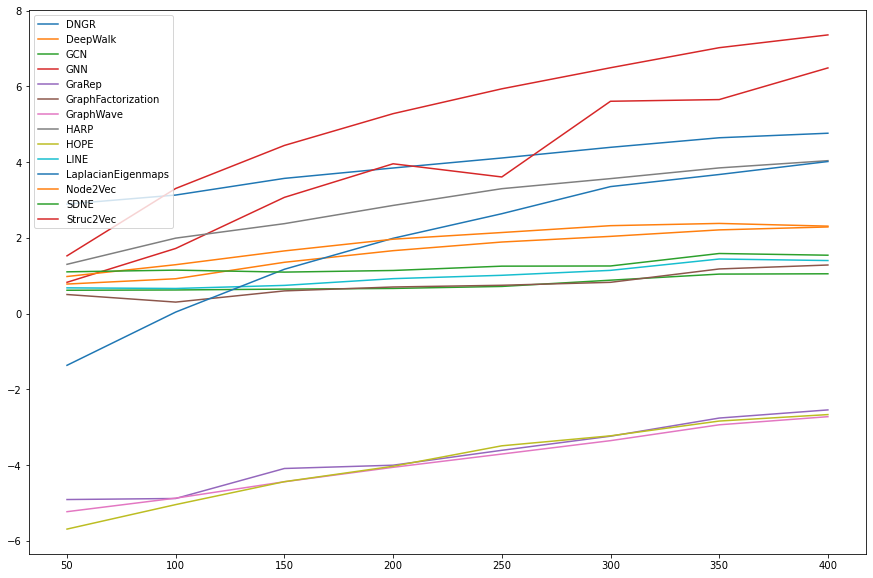

In [49]:
rcParams["figure.figsize"] = 15, 10
for i in method_result_dict.keys():
    curv = np.array(method_result_dict[i])
    name = str(i).split(".")[3]
    name = name.split("'")[0]
    plt.plot(curv[:, 0], np.log(curv[:, 1]), label=name)
plt.legend()
plt.show()
    

# Measure Time and Python/TF2.4 memory usage (future purpose)

In [ ]:
import os, sys
import contextlib

graph, labels = rlg.generate_clusters_graph(200, 5, 0.03, 0.95)
methods = [(method_name, method_class) for method_name, method_class in inspect.getmembers(rle) if method_name not in ("GCN", "GNN", "__builtins__")][:12]
profiling_results = []
for method_name,method_class in methods:
    if isTFMethod[method_name]:
        initial_mem_usage = tf.config.experimental.get_memory_usage()
        print(f"Profiling {method_name} (TF)")
        with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
            profile_method(method_class, graph=graph)
        final_memory_usage = tf.config.experimental.get_memory_usage()
        mu_diff = final_memory_usage - initial_mem_usage
        profiling_results[-1].append(("TF Memory usage", 
                                      mu_diff, 
                                      format_bytes(mu_diff)))
    else:
        print(f"Profiling {method_name} (TF)")
        with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
            profile_method(method_class, graph=graph)

initial_mem_usage = tf.config.experimental.get_memory_usage()
print(f"Profiling GCN")
with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
    profile_method(rle.GCN, graph=graph, Y=labels)
final_memory_usage = tf.config.experimental.get_memory_usage()
        mu_diff = final_memory_usage - initial_mem_usage
        profiling_results[-1].append(("TF Memory usage", 
                                      mu_diff, 
                                      format_bytes(mu_diff)))
        
labelsGNN = np.array([np.arange(len(labels)),labels]).T
initial_mem_usage = tf.config.experimental.get_memory_usage()
print(f"Profiling GNN")
with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
    profile_method(rle.GCN, graph=graph, Y=labelsGNN)
final_memory_usage = tf.config.experimental.get_memory_usage()
mu_diff = final_memory_usage - initial_mem_usage
profiling_results[-1].append(("TF Memory usage", 
                              mu_diff, 
                              format_bytes(mu_diff)))

In [89]:
profiling_results

[[relegy.embeddings.DNGR.DNGR,
  (2928640, 3268608, '48.85s', 48.84972786903381),
  'RSS:   2.93MB | VMS:   3.27MB | time:   48.85s'],
 [relegy.embeddings.DeepWalk.DeepWalk,
  (19689472, 19738624, '5.19s', 5.185544013977051),
  'RSS:  19.69MB | VMS:  19.74MB | time:    5.19s'],
 [relegy.embeddings.GraRep.GraRep,
  (-18100224, -18120704, '27.65ms', 0.027652263641357422),
  'RSS:  -18.1MB | VMS: -18.12MB | time:  27.65ms'],
 [relegy.embeddings.GraphFactorization.GraphFactorization,
  (32768, 0, '1.98s', 1.9834721088409424),
  'RSS:  32.77kB | VMS:       0B | time:    1.98s'],
 [relegy.embeddings.GraphWave.GraphWave,
  (-1425408, -1380352, '31.12ms', 0.03112030029296875),
  'RSS:  -1.43MB | VMS:  -1.38MB | time:  31.12ms'],
 [relegy.embeddings.HARP.HARP,
  (19386368, 19357696, '16.88s', 16.88197898864746),
  'RSS:  19.39MB | VMS:  19.36MB | time:   16.88s'],
 [relegy.embeddings.HOPE.HOPE,
  (-18169856, -18186240, '25.31ms', 0.02531290054321289),
  'RSS: -18.17MB | VMS: -18.19MB | time:  2